### ECFT-VS-pipeline

The main idea of ECFT-VS-pipeline is to test a preliminary pipeline on small data that has negative value and determine a robust pipeline to implement on larger dataset.

In this pipeline we try every method with every possible combination.

1. Data prepartion :
    - In this step, two different data sets are prepared:
        1. IC50 data : Structures with IC50 only
        2. Score data : Calculated score to rank data accordinlgy.
        After loading them, common IDs are extracted to differentiate IC50 on different plots
2. Filtering :
    - In order to have a better results we are trying:
        1. Most Common Scaffold : Extract MCS using different cutoffs and test results.
        2. Ligand-based pharmacophore search : hasn't implemented yet.

3. Docking :
    - Two docking tools are implemented using score data:
        1. SMINA
        2. GNINA

4. Rescoring :
    - Three different scoring functions are implemented and compared between each others 
        1. RFscoreVS
        2. VINARDO
        3. AD4
5. Clustering :
    - In order to decrease dimensionality of the data, Butina clustering is implemented using tanimoto similarity metric on the fingerprints.
    - It will be implemented on larger data.

### To mention a pipeline's results, following steps should be mentioned:
1. Filtering 
    - Activity threshold (15, 20)
    - Sorting type of activity score (IC50 values, calculated score)
    - Size of data after filtering (80, 120, 124, 212) out of 212
2. Docking 
    - Type of docking tool : SMINA or GNINA
3. Rescoring 
    - RFscoreVS , VINARDO, AD4 or None


### Conclusion 

#### Best pearson rank correlation is resulted from :
1. Pipeline 1 has Pearson correlation equals $0.5567$
    - Filtering using MCS (20 micromolar, IC50, 120 molecules out of 212) 
    - GNINA
    - None
2. Pipeline 2 has Pearson correlation equals $0.5329$
    - Filtering using MCS (20 micromolar, IC50, 120 molecules out of 212) 
    - SMINA or GNINA (GNINA better with) $0.0009$
    - AD4

3. Pipeline 3 has spearman correlation equals $0.5311$
    - None
    - GNINA 
    - None

#### Best scoring function yet is AD4.

## Import important dependencies and paths

In [14]:
import os 
import numpy as np
import pandas as pd
from clustering import *
from data_preparation import *
from docking import *
from filtering import *
from rdkit.ML.Cluster import Butina
from rdkit import Chem, DataStructs
from rdkit.Chem import PandasTools, SDMolSupplier, AllChem, rdFingerprintGenerator
from scipy.stats import spearmanr
from rescoring import rescoring_functions
from matplotlib import pyplot as plt
from utility import rank_correlation, prcoess_ranking_data, consensus_ranking_generator


In [15]:
#To disaply warning messages
RDLogger.DisableLog('rdApp.*')  

#### If there is more than one snapshot of a trajectory.
    - make a directory for all snapshots inside **data** directory
    - For now , we work with snapshot A

In [3]:
snapshot_ID = 'A'
protein_file = f"data/{snapshot_ID}/protein_protoss_noligand.pdb"
ref_file = f"data/{snapshot_ID}/ref_ligand.pdb"

### Load IC50 data

In [4]:
df_IC50 = create_IC50_sample()
df_IC50.head()

IC50 Molecules already exist.


,Activity,smiles,ID,Molecule
0,3.1,O=C(O)c1cc(OCc2cccc(-c3cccc(Oc4ccc(C(F)(F)F)cc...,HIPS6989,<rdkit.Chem.rdchem.Mol object at 0x7fafb39d1580>
1,3.2,O=C(O)c1cc(OCc2cccc(-c3cccc(OCc4ccc(OC(F)(F)F)...,HIPS7002,<rdkit.Chem.rdchem.Mol object at 0x7fafb39d1270>
2,3.5,O=C(O)c1cc(OCc2cccc(-c3cccc(OCc4ccc(C(F)(F)F)c...,HIPS7000,<rdkit.Chem.rdchem.Mol object at 0x7fafb39d1820>
3,4.7,Cc1ccc(Oc2cccc(-c3cccc(COc4ccc(O)c(C(=O)O)c4)c...,HIPS6994,<rdkit.Chem.rdchem.Mol object at 0x7fafb39d1900>
4,5.0,O=C(O)c1cc(OCc2cccc(-c3cccc(Oc4ccc(Cl)cc4)c3)c...,HIPS6991,<rdkit.Chem.rdchem.Mol object at 0x7fafb39d19e0>


### Prepare larger dataset with negative samples with already calculated score.

In [5]:
data_name = 'ecft_scores'
data_size, df_scores = add_negative_data(data_name)
print(f"Now we have loaded {data_size} molecules save in data/ligands/{data_name}.sdf, which contains negative samples.")

Now we have loaded 212 molecules save in data/ligands/ecft_scores.sdf, which contains negative samples.


#### Map correlation between IC50 data and score data

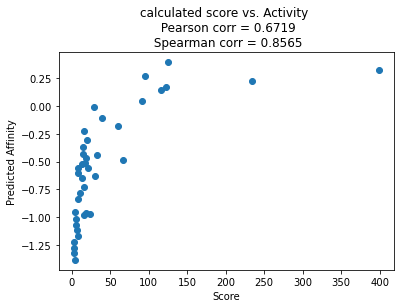

In [6]:
df_IC50.rename(columns = {'ID':'HIPS code'}, inplace = True)
merged_df_data = pd.merge(df_IC50, df_scores, on="HIPS code", how="left")
merged_df_data[['score', 'Activity']] = merged_df_data[['score', 'Activity']].apply(pd.to_numeric)

pearson_corr = merged_df_data['Activity'].corr(merged_df_data['score'])
spearman_corr = merged_df_data[['Activity', 'score']].corr(method='spearman').iloc[0,1]

plt.scatter(merged_df_data['Activity'], merged_df_data['score'])
plt.xlabel('Score')
plt.ylabel('Predicted Affinity')
plt.title(f'calculated score vs. Activity \n Pearson corr = {pearson_corr:.4f}\n Spearman corr = {spearman_corr:.4f}')
plt.show()

### Pre-filtering step

#### MCS extraction using IC50 to sort the data set

In [7]:
activity_cutoff = 20
sort_order = 'IC50'
mcs_IC50 = find_MCS(df_scores, df_IC50, activity_cutoff, sort_order)

#### Draw IC50 MCS

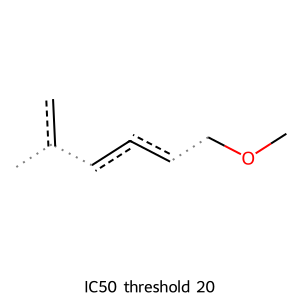

In [8]:
m1 = Chem.MolFromSmarts(mcs_IC50.smartsString)
Draw.MolToImage(m1, legend=f"{sort_order} threshold {activity_cutoff}")

In [9]:
data_name, data_size = write_mcs_file(df_scores, m1, f"scaffold_{sort_order}_{activity_cutoff}")

,HIPS code,ROMol,score
311,HIPS314,<rdkit.Chem.rdchem.Mol object at 0x7f013b999350>,0.493686
4361,HIPS5021,<rdkit.Chem.rdchem.Mol object at 0x7f013b366740>,1.153769
4363,HIPS5023,<rdkit.Chem.rdchem.Mol object at 0x7f013b366820>,0.410179
4366,HIPS5026,<rdkit.Chem.rdchem.Mol object at 0x7f013b366970>,1.153769
4367,HIPS5027,<rdkit.Chem.rdchem.Mol object at 0x7f013b3669e0>,0.632401


#### MCS extraction using given scores to sort the data set

In [10]:
activity_cutoff = 20
sort_order = 'score'
mcs_score = find_MCS(df_scores, df_IC50, activity_cutoff, sort_order)

#### Draw Score MCS

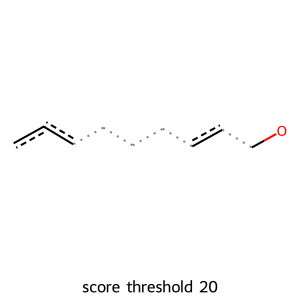

In [11]:
m2 = Chem.MolFromSmarts(mcs_score.smartsString)
Draw.MolToImage(m2, legend=f"{sort_order} threshold {activity_cutoff}")

### Extract common IDs from score data and IC50 data

In [7]:
common_ID = df_scores[df_scores['HIPS code'].isin(df_IC50['HIPS code'])]['HIPS code']
print(f"There are {len(common_ID)} structures that found to be common in both data sets.")

There are 39 structures that found to be common in both data sets.



### Data preparation
####  1. Protein is prepared with protoss on ProteinPlus server (Done).
####  2. Ligand will be prepared using Gypsum-DL.

In [13]:
# Determine path of data set and run Gypsum-dl
prepared_molecules_path = run_gypsumdl(f"data/ligands/{data_name}.sdf", f"gypsum_dl_success_cleaned_{data_size}")


If you use Gypsum-DL in your research, please cite:

Ropp, Patrick J., Jacob O. Spiegel, Jennifer L. Walker, Harrison Green,
Guillermo A. Morales, Katherine A. Milliken, John J. Ringe, and Jacob D. Durrant.
(2019) Gypsum-DL: An Open-source Program for Preparing Small-molecule Libraries for 
Structure-based Virtual Screening. Journal of Cheminformatics 11:1. 
doi:10.1186/s13321-019-0358-3.

    Gypsum-DL-generated variants, we have identified a number of substructures
    that, though technically possible, strike us as improbable or otherwise
    poorly suited for virtual screening. We strongly recommend removing these by
    running Gypsum-DL with the --use_durrant_lab_filters option.

Loading molecules from scaffold_IC50_20.sdf...
Desalting all molecules (i.e., keeping only largest fragment).
    Contents of MolContainers
        MolContainer #0 (HIPS314)
            Mol #0: Nc1nnc(-c2cccc(OC(F)(F)F)c2)o1
        MolContainer #1 (HIPS5021)
            Mol #0: OCc1cc(OCc2cccc3ccccc23)

,source,output_folder,separate_output_files,add_pdb_output,add_html_output,num_processors,start_time,end_time,run_time,min_ph,...,cache_prerun,test,Parallelizer,ID,Molecule,UniqueID,SMILES,Energy,Genealogy,score
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,HIPS314,<rdkit.Chem.rdchem.Mol object at 0x7f013afff7b0>,1,Nc1nnc(-c2cccc(OC(F)(F)F)c2)o1,57.46693845259453,Nc1nnc(-c2cccc(OC(F)(F)F)c2)o1 (3D coordinates...,0.493686
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,HIPS5021,<rdkit.Chem.rdchem.Mol object at 0x7f013afff6d0>,2,OCc1cc(OCc2cccc3ccccc23)ccc1O,47.30952149524697,OCc1cc(OCc2cccc3ccccc23)ccc1O (3D coordinates ...,1.153769
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,HIPS5023,<rdkit.Chem.rdchem.Mol object at 0x7f013afff660>,3,O=C(O)c1cccc(OCc2cccc3ccccc23)c1,44.83142089365485,O=C(O)c1cccc(OCc2cccc3ccccc23)c1 (3D coordinat...,0.410179
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,HIPS5026,<rdkit.Chem.rdchem.Mol object at 0x7f013afff5f0>,4,COC(=O)c1cc(OCc2cccc3ccccc23)ccc1O,46.08019991735697,COC(=O)c1cc(OCc2cccc3ccccc23)ccc1O (3D coordin...,1.153769
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,HIPS5027,<rdkit.Chem.rdchem.Mol object at 0x7f013afff580>,5,Cc1ccc(OCc2cccc3ccccc23)cc1C(=O)O,51.175008773650504,Cc1ccc(OCc2cccc3ccccc23)cc1C(=O)O (3D coordina...,0.632401
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,HIPS7125,<rdkit.Chem.rdchem.Mol object at 0x7f013b01d660>,116,O=C(O)c1cc(OCc2cccc(-n3cc(C4CCCC4)nn3)c2)ccc1O,NaN,O=C(O)c1cc(OCc2cccc(-n3cc(C4CCCC4)nn3)c2)ccc1O...,0.312708
117,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,HIPS7126,<rdkit.Chem.rdchem.Mol object at 0x7f013b01d5f0>,117,CC(C)(C)c1cn(-c2cc(COc3ccc(O)c(C(=O)O)c3)cc(-c...,119.24814198632698,CC(C)(C)c1cn(-c2cc(COc3ccc(O)c(C(=O)O)c3)cc(-c...,-0.481383
118,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,HIPS7127,<rdkit.Chem.rdchem.Mol object at 0x7f013b01d580>,118,O=C(O)c1cc(OCc2cc(-c3cncc4ccccc34)cc(-n3cc(C4C...,NaN,O=C(O)c1cc(OCc2cc(-c3cncc4ccccc34)cc(-n3cc(C4C...,-0.699296
119,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,HIPS7128,<rdkit.Chem.rdchem.Mol object at 0x7f013b01d510>,119,O=C(O)c1cc(OCc2cc(-c3cncc4ccccc34)cc(-n3cc(COc...,129.3443086049972,O=C(O)c1cc(OCc2cc(-c3cncc4ccccc34)cc(-n3cc(COc...,0.526927


,Molecule,ID,score
1,<rdkit.Chem.rdchem.Mol object at 0x7f013afff7b0>,HIPS314,0.493686
2,<rdkit.Chem.rdchem.Mol object at 0x7f013afff6d0>,HIPS5021,1.153769
3,<rdkit.Chem.rdchem.Mol object at 0x7f013afff660>,HIPS5023,0.410179
4,<rdkit.Chem.rdchem.Mol object at 0x7f013afff5f0>,HIPS5026,1.153769
5,<rdkit.Chem.rdchem.Mol object at 0x7f013afff580>,HIPS5027,0.632401
...,...,...,...
116,<rdkit.Chem.rdchem.Mol object at 0x7f013b01d660>,HIPS7125,0.312708
117,<rdkit.Chem.rdchem.Mol object at 0x7f013b01d5f0>,HIPS7126,-0.481383
118,<rdkit.Chem.rdchem.Mol object at 0x7f013b01d580>,HIPS7127,-0.699296
119,<rdkit.Chem.rdchem.Mol object at 0x7f013b01d510>,HIPS7128,0.526927


## Docking

## 1. DiffDOCK
### Prepare ligand protein csv file for DiffDock

### Run DiffDock (Left to run on cluster)

In [15]:
#run_diffdock(snapshot_ID, data_size)

## 2. GNINA 1.0 docking 
### with -cnn crossdock_default2018

#### Run GNINA docking

In [ ]:
## Data size of IC50 scaffold is 80 while score scaffold is 124 with activity 10 micromolar
## Data size of IC50 scaffold with activity 20 is 120

#data_size = 124

In [16]:
sdf_name = f'docked_gnina_poses_{snapshot_ID}_{data_size}.sdf'

In [ ]:
gnina_docking(snapshot_ID, sdf_name, prepared_molecules_path, ref_file)

Snapshot A is already docked with GNINA v 1.0


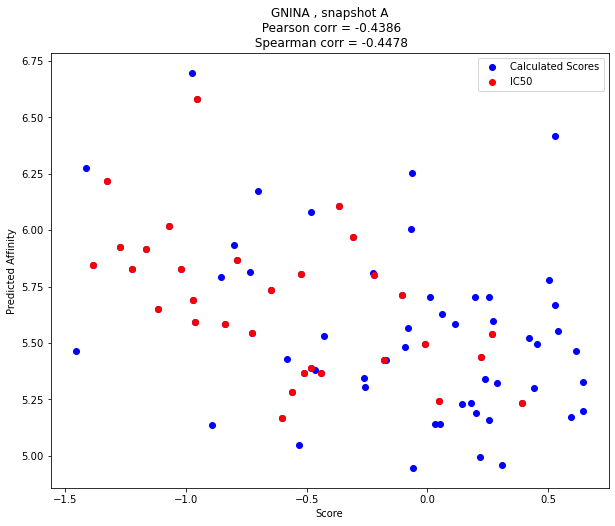

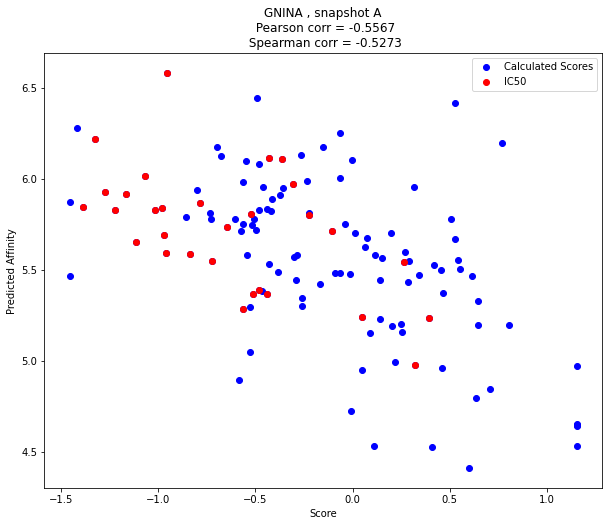

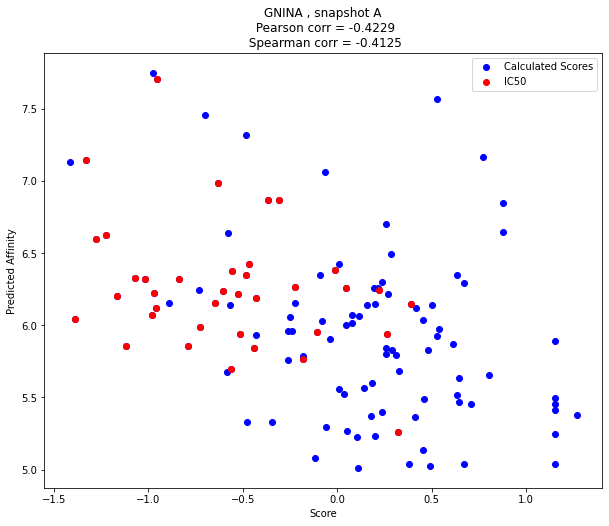

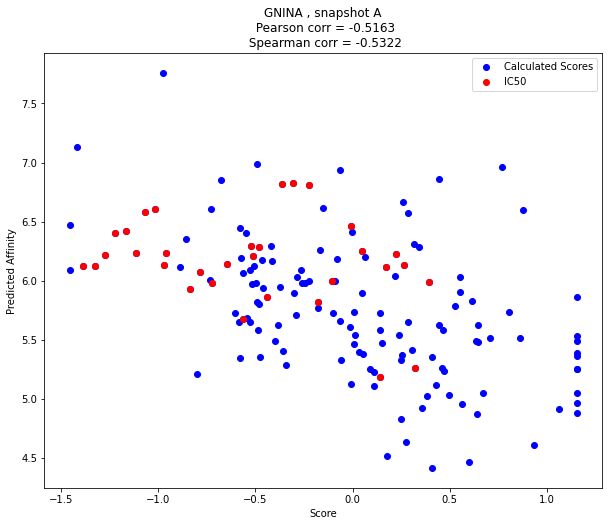

In [17]:
for ind in ['80', '124', '120', '212']:
    sdf_name = f'docked_gnina_poses_{snapshot_ID}_{ind}.sdf'
    gnina_results_path = f'data/{snapshot_ID}/{sdf_name}'
    rank_correlation(gnina_results_path, common_ID)

### SMINA docking

#### Run SMINA docking --cnn_scoring=none

In [19]:
sdf_name = f'docked_smina_poses_{snapshot_ID}_{data_size}.sdf'

In [20]:
smina_docking(snapshot_ID, sdf_name, prepared_molecules_path, ref_file)

Snapshot A is already docked with SMINA


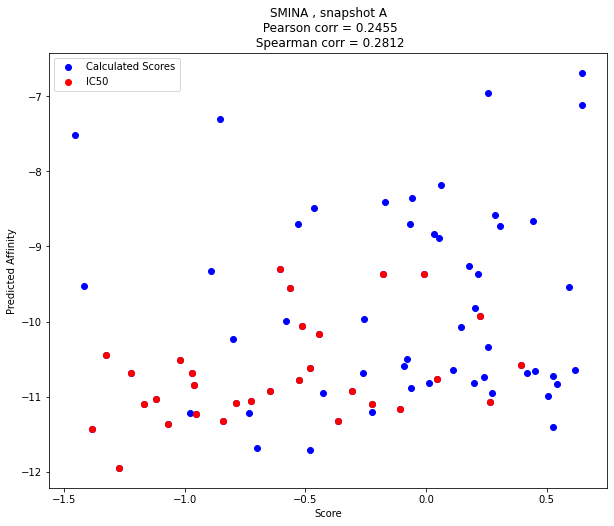

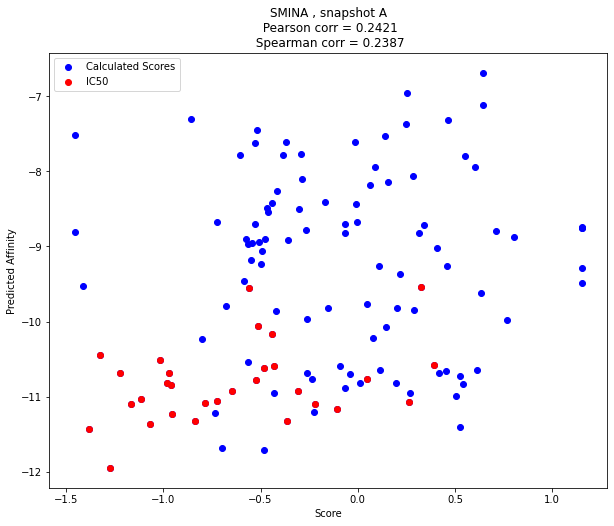

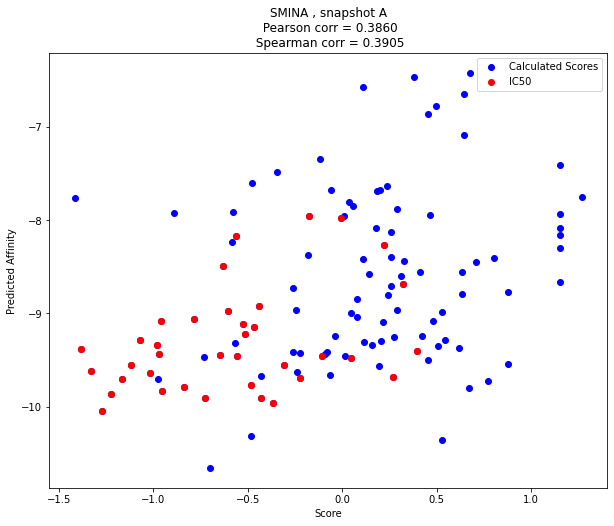

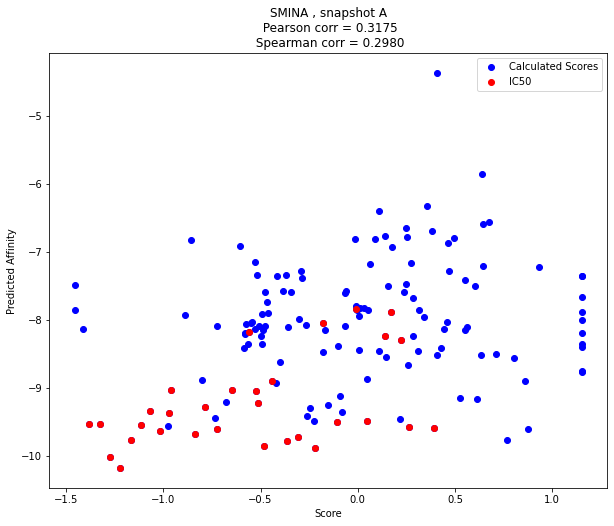

In [21]:
for ind in ['80', '124', '120','212']:
    sdf_name = f'docked_smina_poses_{snapshot_ID}_{ind}.sdf'
    smina_results_path = f'data/{snapshot_ID}/{sdf_name}'
    rank_correlation(smina_results_path, common_ID)


### Try rescoring function with every possbile combination of two docking tools and three rescoring functions.

80 



rescoring directory is already created.
SMINA is now rescored ... 



RF-SCORE-VS Running ... 





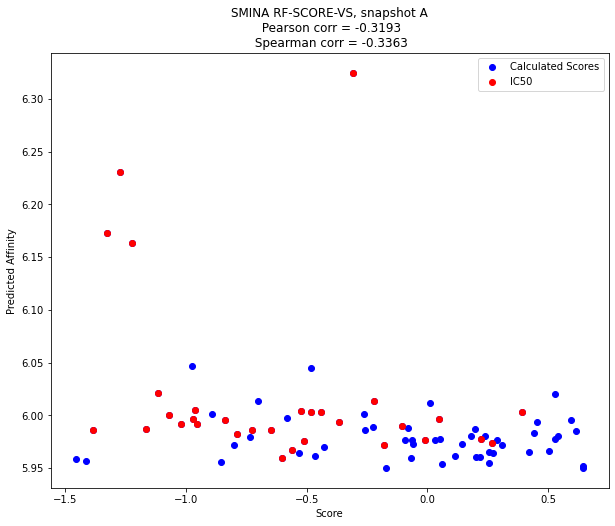

VINARDO Running ... 





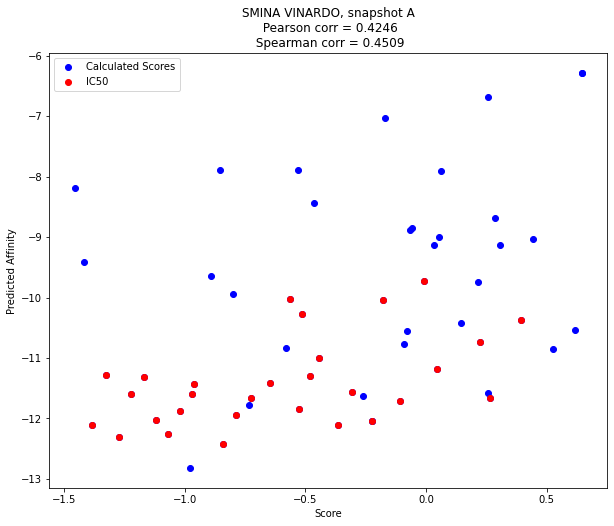

AD4 Running ... 





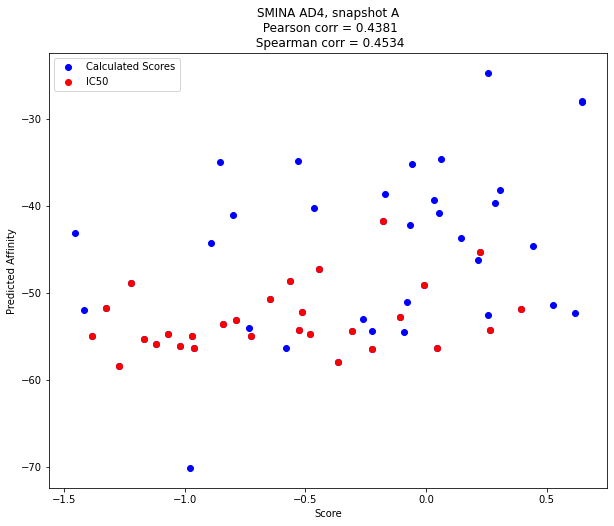

GNINA is now rescored ... 



RF-SCORE-VS Running ... 





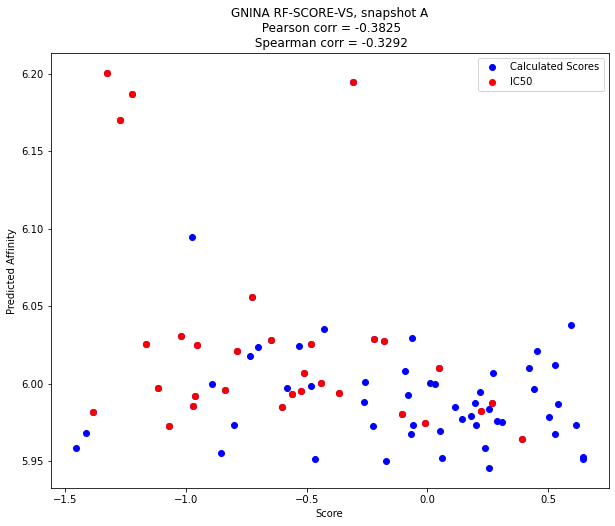

VINARDO Running ... 





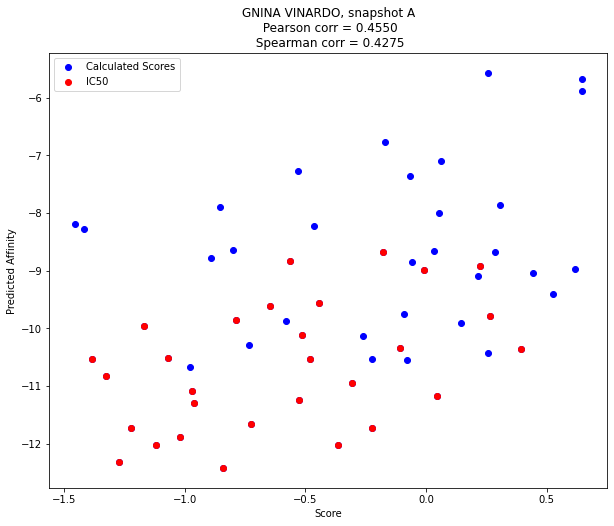

AD4 Running ... 





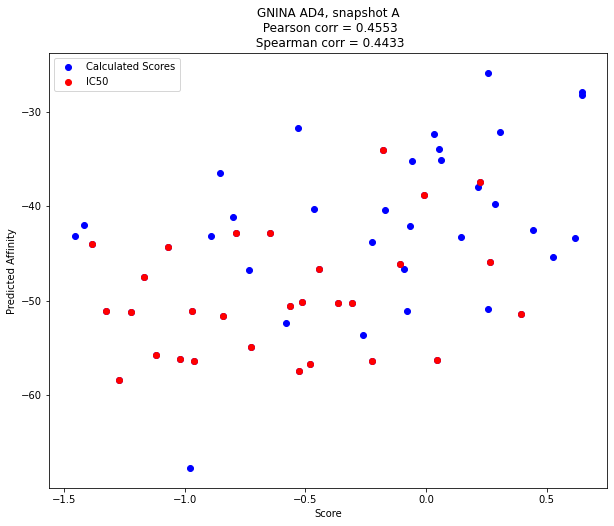

120 



rescoring directory is already created.
SMINA is now rescored ... 



RF-SCORE-VS Running ... 





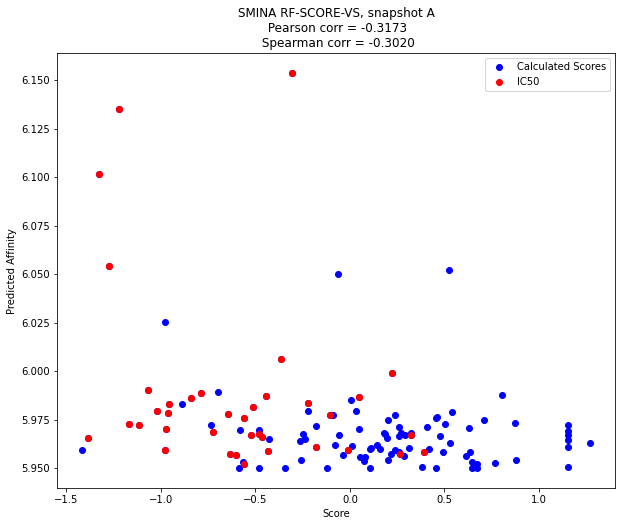

VINARDO Running ... 





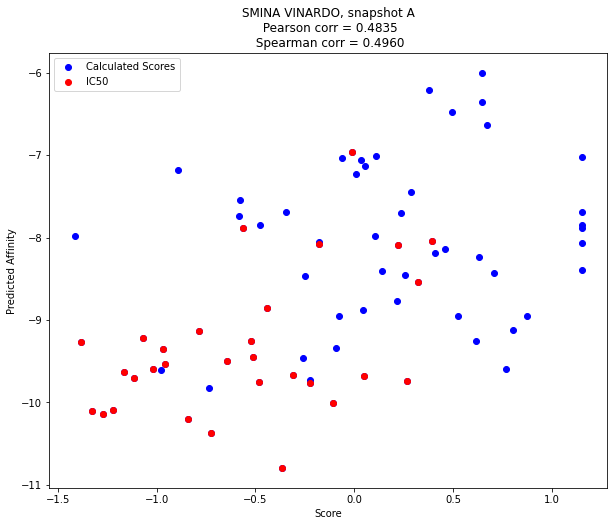

AD4 Running ... 





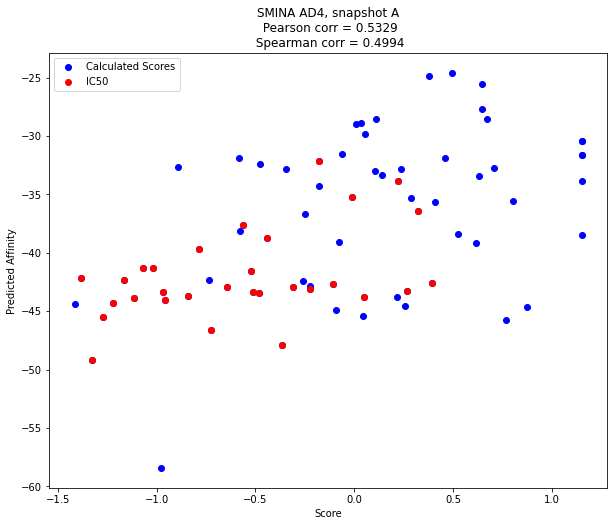

GNINA is now rescored ... 



RF-SCORE-VS Running ... 





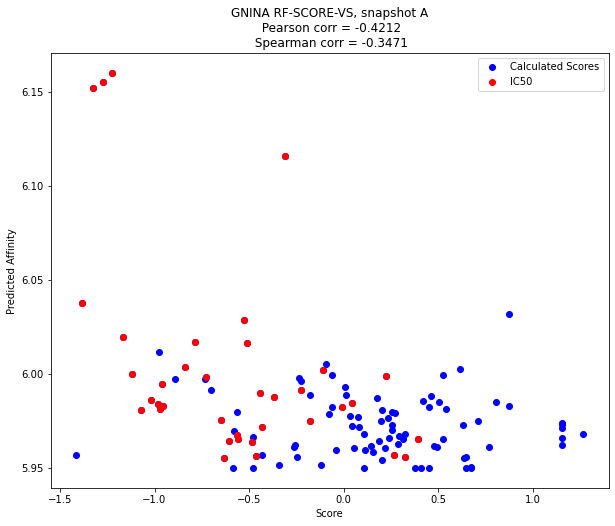

VINARDO Running ... 





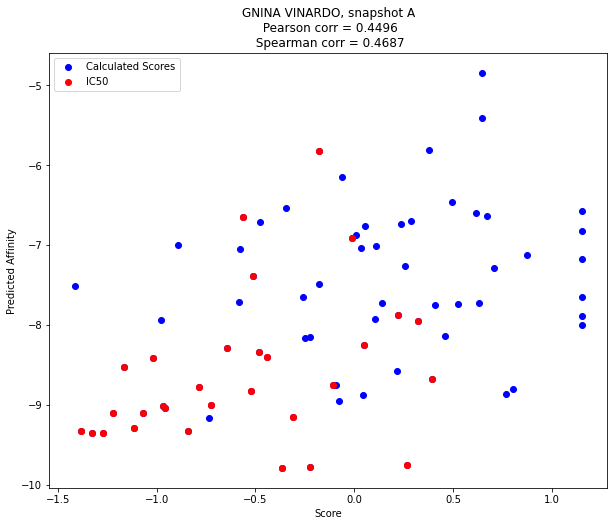

AD4 Running ... 





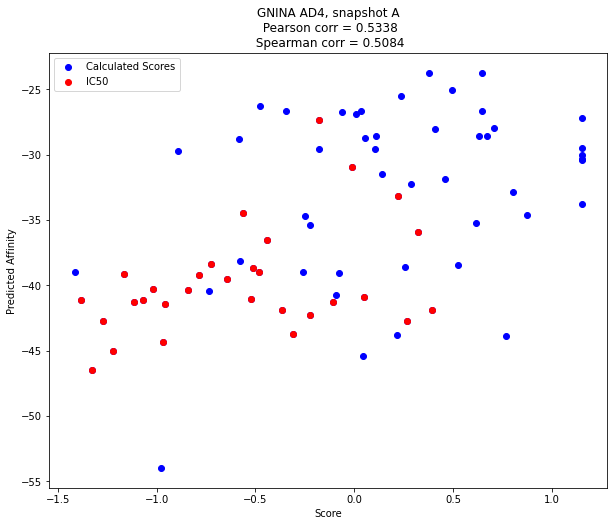

124 



rescoring directory is already created.
SMINA is now rescored ... 



RF-SCORE-VS Running ... 





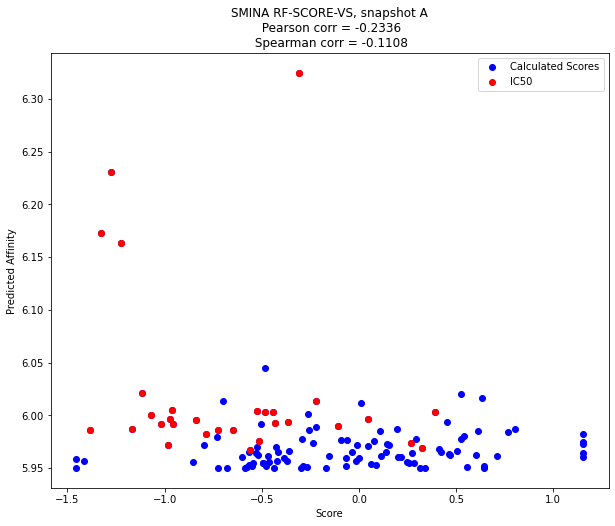

VINARDO Running ... 





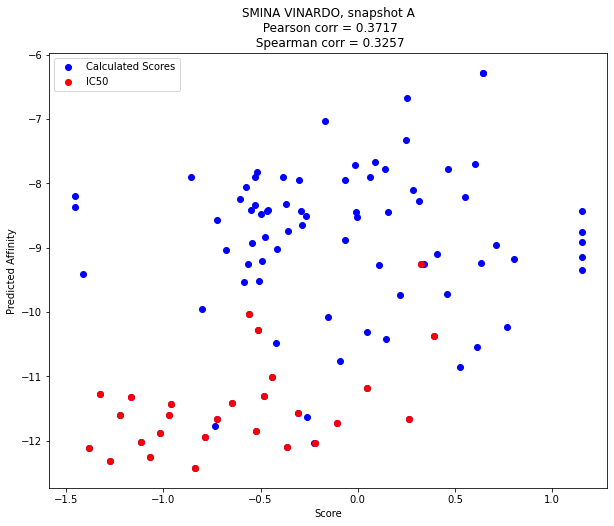

AD4 Running ... 





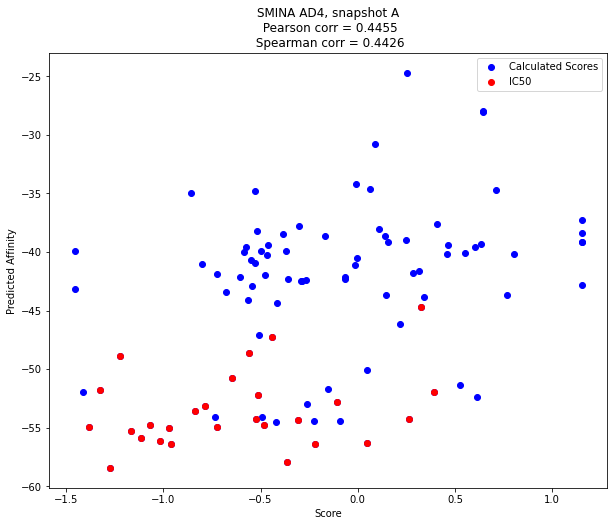

GNINA is now rescored ... 



RF-SCORE-VS Running ... 





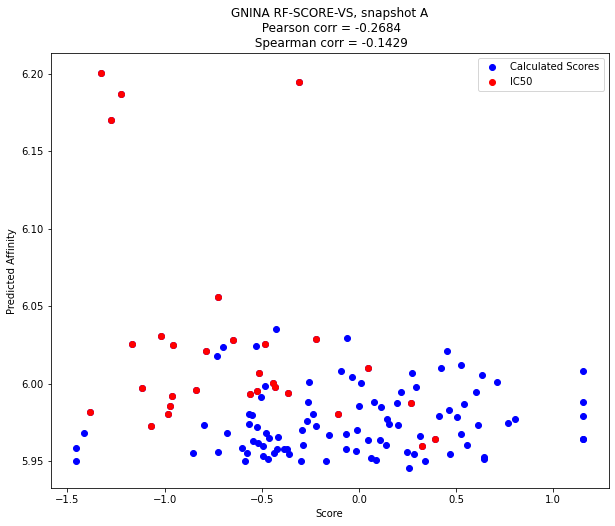

VINARDO Running ... 





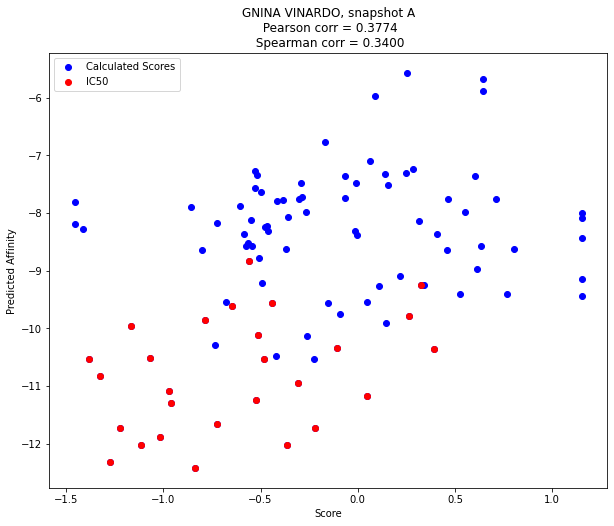

AD4 Running ... 





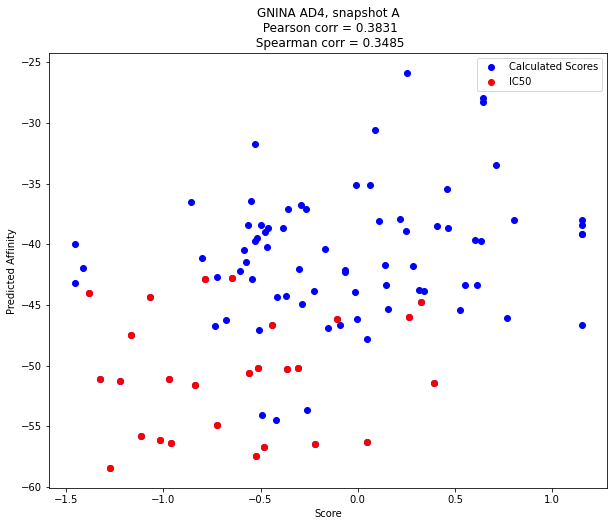

212 



rescoring directory is already created.
SMINA is now rescored ... 



RF-SCORE-VS Running ... 





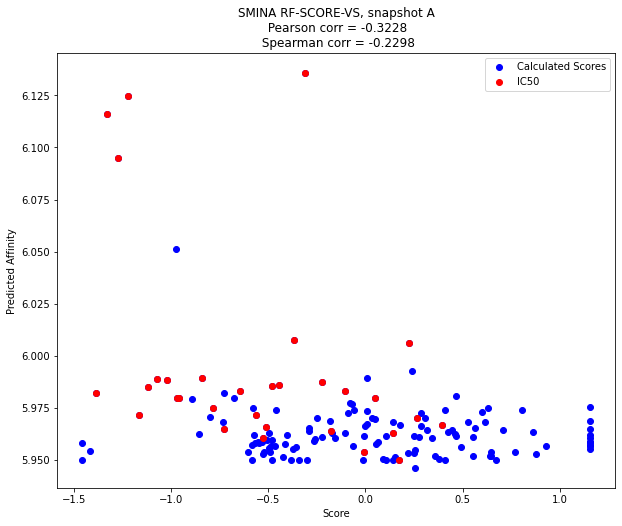

VINARDO Running ... 





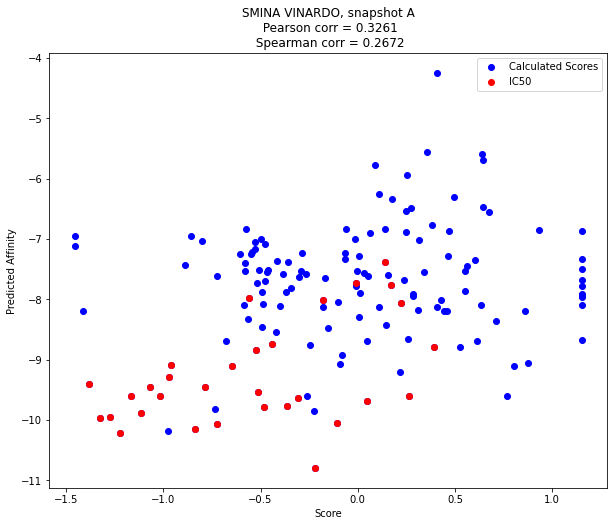

AD4 Running ... 





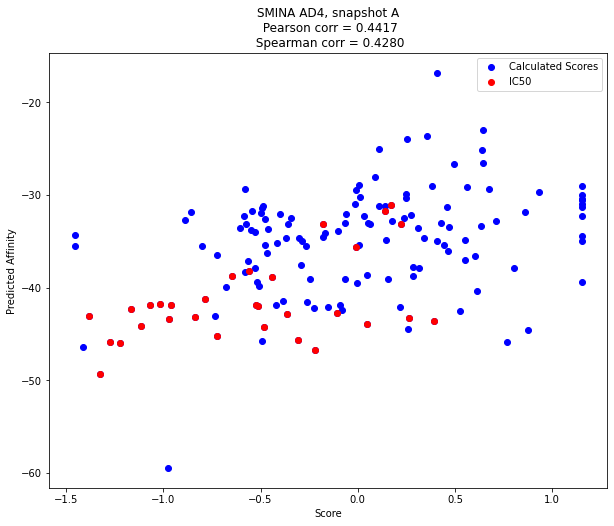

GNINA is now rescored ... 



RF-SCORE-VS Running ... 





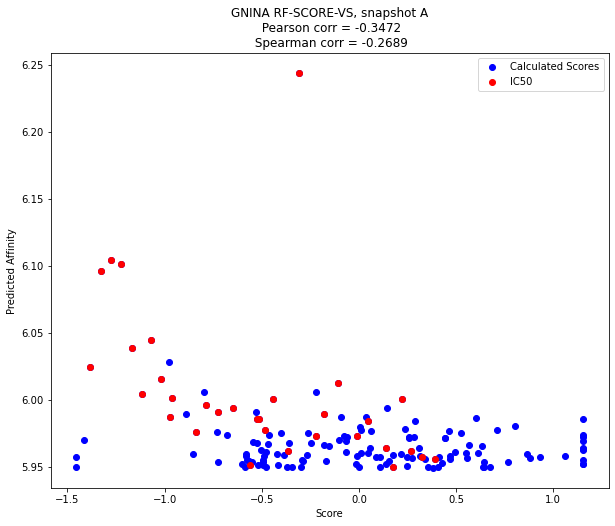

VINARDO Running ... 





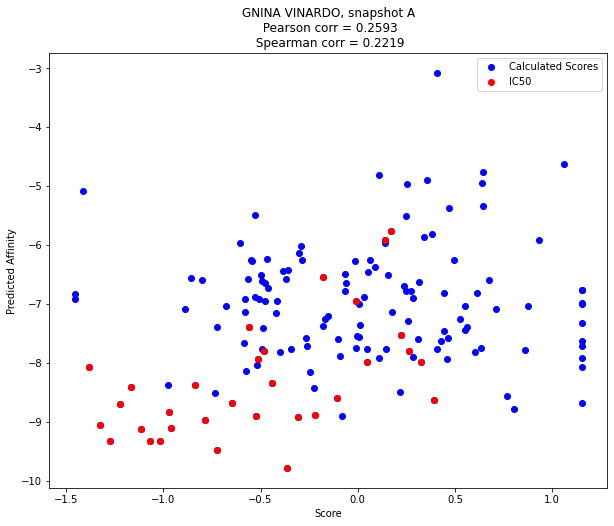

AD4 Running ... 





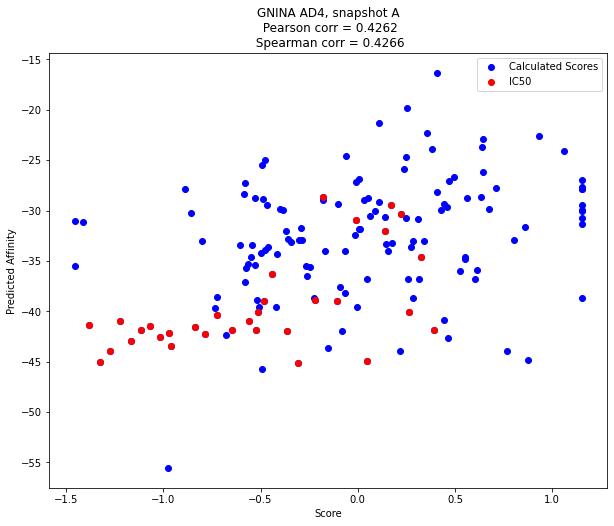

In [24]:
for size in ['80','120','124','212']:
    print(size,'\n\n\n')
    rescoring_functions(['smina', 'gnina'], ['rf-score-vs', 'vinardo', 'ad4'], snapshot_ID, size, common_ID)

### FP generating and clustering based on Tanimoto similarity metric for larger data

In [ ]:
# Add column with Morgan fingerprint
docked_df = PandasTools.LoadSDF(gnina_results_path, idName='ID', molColName='Molecule', strictParsing=False)
docked_df['MorganFP'] = docked_df.Molecule.apply(morgan_fp_generator)
docked_df.head()

,score,minimizedAffinity,CNNscore,CNNaffinity,CNN_VS,ID,Molecule,MorganFP
0,0.493686,-6.66493,0.8810666203,5.1966133118,4.5785627365,HIPS314,<rdkit.Chem.rdchem.Mol object at 0x7f7d8cdfd900>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,0.493686,-5.72351,0.7941305041,5.3596706390,4.2562780380,HIPS314,<rdkit.Chem.rdchem.Mol object at 0x7f7d8cdfdf90>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,0.493686,-6.79467,0.7786121964,5.0351457596,3.9204258919,HIPS314,<rdkit.Chem.rdchem.Mol object at 0x7f7d8cdfd4a0>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,-0.265965,-7.77134,0.3771519363,6.0932388306,2.2980768681,HIPS341,<rdkit.Chem.rdchem.Mol object at 0x7f7d8cdfddd0>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,-0.265965,-8.07241,0.3593167067,6.2334060669,2.2397668362,HIPS341,<rdkit.Chem.rdchem.Mol object at 0x7f7d8cdfd660>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


#### Generate tanimoto similarity matrix

In [ ]:
tanimoto_matrix = tanimoto_distance_matrix((docked_df.MorganFP.to_list()))

#### Choice of butina clustering cutoff 
**Inspired by T05 teachOpenCADD Talktorial**

### Choice of cutoff.
#### Choose the cutoff that has clusters equal or bigger than used data.

In [ ]:
cutoff = choice_of_cutoff(docked_df)
cutoff

0.9

In [ ]:
#Save cluster centers as SDF
# cutoff is chosen to be 0.1 which has 88 clusters
cutoff = 0.1

butina_clusters = butina_clustering(docked_df.MorganFP.to_list(), cutoff=cutoff)

cluster_centers_ind = [c[0] for c in butina_clusters]
cluster_centers_df = docked_df[docked_df.index.isin(cluster_centers_ind)]
display(cluster_centers_df.sort_values('minimizedAffinity'))
cluster_path = 'data/ligands/clustered_poses_212.sdf'

PandasTools.WriteSDF(cluster_centers_df, cluster_path,idName="ID", molColName='Molecule', properties=cluster_centers_df.columns)

,score,minimizedAffinity,CNNscore,CNNaffinity,CNN_VS,ID,Molecule,MorganFP
391,0.176673,-5.16409,0.6609857678,4.5137567520,2.9835290909,HIPS6785,<rdkit.Chem.rdchem.Mol object at 0x7f7d8cd55c10>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
222,0.640496,-5.32986,0.8656404018,5.1880092621,4.4909505844,HIPS5963,<rdkit.Chem.rdchem.Mol object at 0x7f7d8ccf6510>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."
223,0.640496,-5.41926,0.7867473364,4.8761281967,3.8362808228,HIPS5963,<rdkit.Chem.rdchem.Mol object at 0x7f7d8ccf63c0>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."
224,0.640496,-5.49521,0.7826318145,5.0785446167,3.9746305943,HIPS5963,<rdkit.Chem.rdchem.Mol object at 0x7f7d8cce8350>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."
379,0.273774,-5.90086,0.6751087904,4.6322088242,3.1272449493,HIPS6708,<rdkit.Chem.rdchem.Mol object at 0x7f7d8cd55270>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...,...,...
458,-0.839276,-8.86450,0.5565002561,5.9264574051,3.2980749607,HIPS6981,<rdkit.Chem.rdchem.Mol object at 0x7f7d8cd454a0>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
259,-0.725974,-8.93809,0.5806342959,6.2956209183,3.6554534435,HIPS6066,<rdkit.Chem.rdchem.Mol object at 0x7f7d8cccb3c0>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
457,-0.839276,-8.94038,0.5596333742,6.4661188126,3.6186559200,HIPS6981,<rdkit.Chem.rdchem.Mol object at 0x7f7d8cd45430>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
366,-0.247372,-8.94737,0.6001500487,6.1496162415,3.6906924248,HIPS6701,<rdkit.Chem.rdchem.Mol object at 0x7f7d8cd55190>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


### 3. DockM8 - using different consensus ranking for different clustering metric

#### 1. Best Exponential Consensus Ranking

Method1_ECR_bestpose_standardised


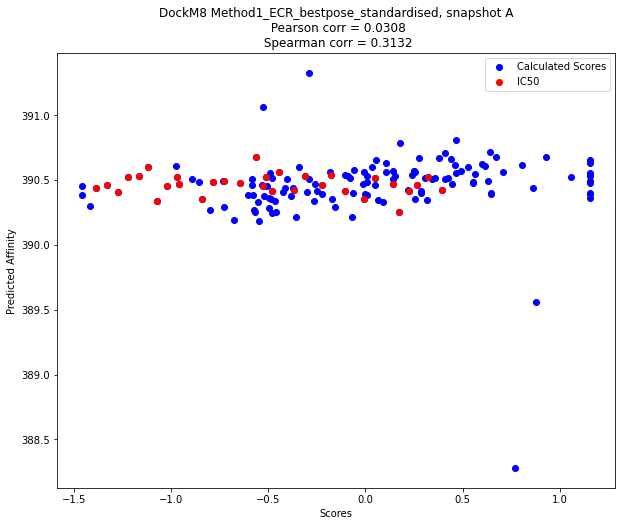

Method1_ECR_RMSD_standardised


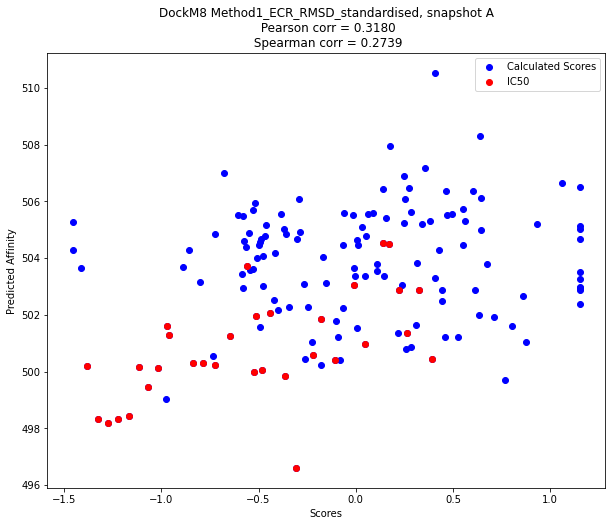

Method1_ECR_spyRMSD_ranked


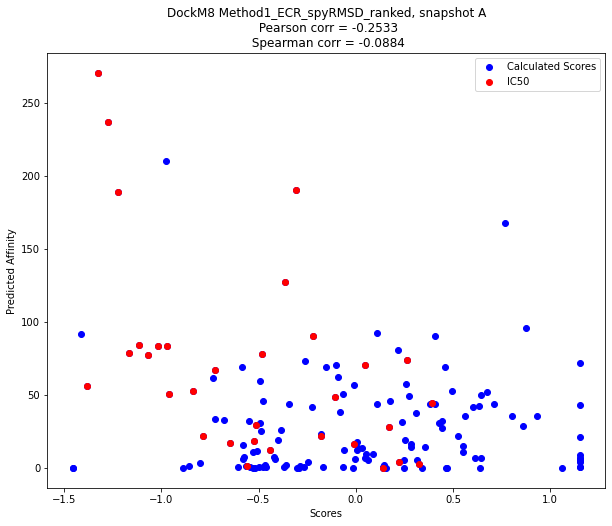

Method1_ECR_RMSD_ranked


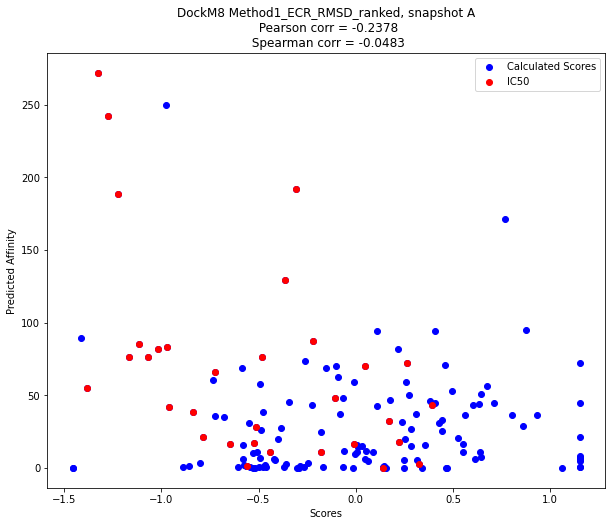

Method1_ECR_spyRMSD_standardised


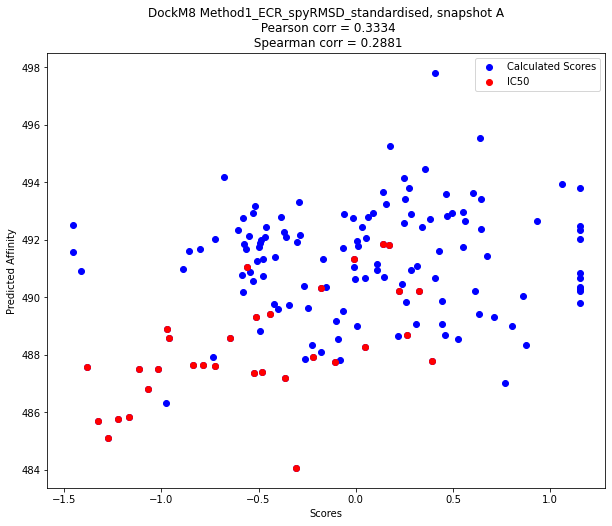

Method1_ECR_bestpose_GNINA_standardised


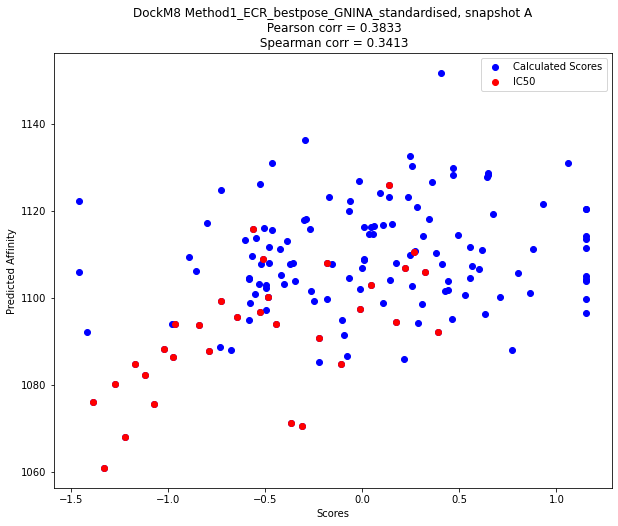

Method1_ECR_bestpose_GNINA_ranked


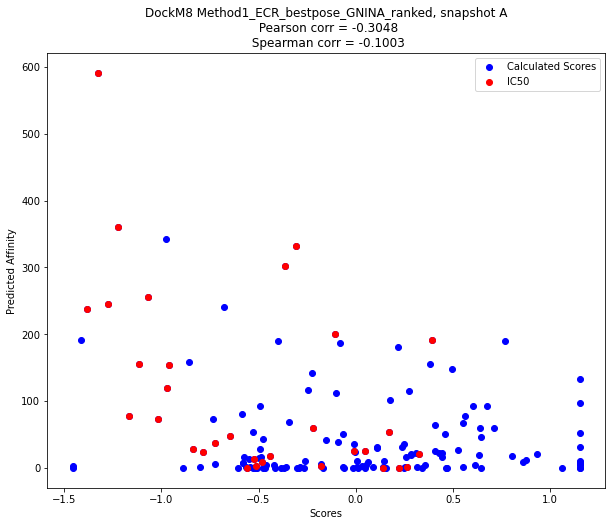

Method1_ECR_bestpose_ranked


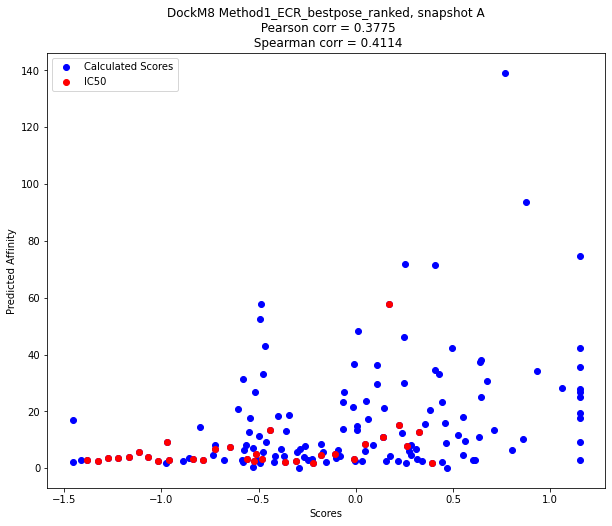

In [11]:
consensus_ranking_generator('method1', common_ID)

#### 2. Average Exponential Consensus Ranking

Method2_ECR_bestpose_standardised


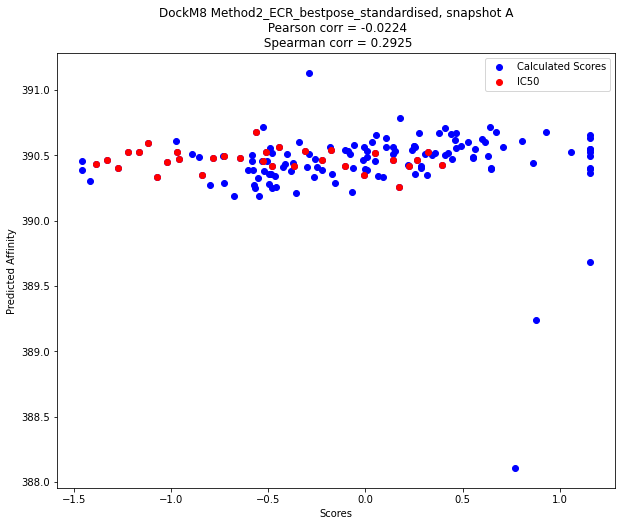

Method2_ECR_RMSD_standardised


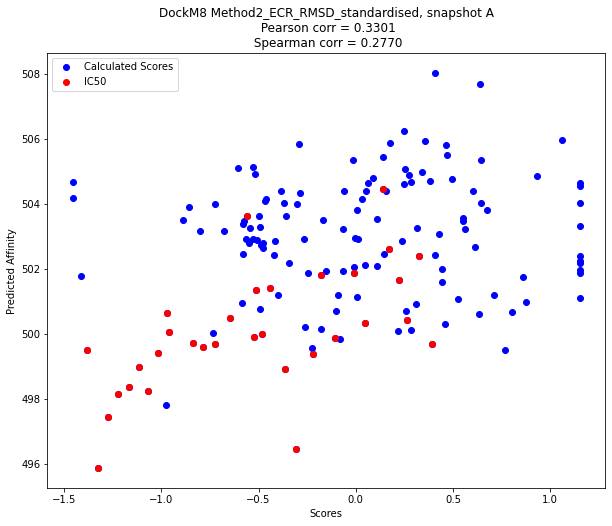

Method2_ECR_spyRMSD_ranked


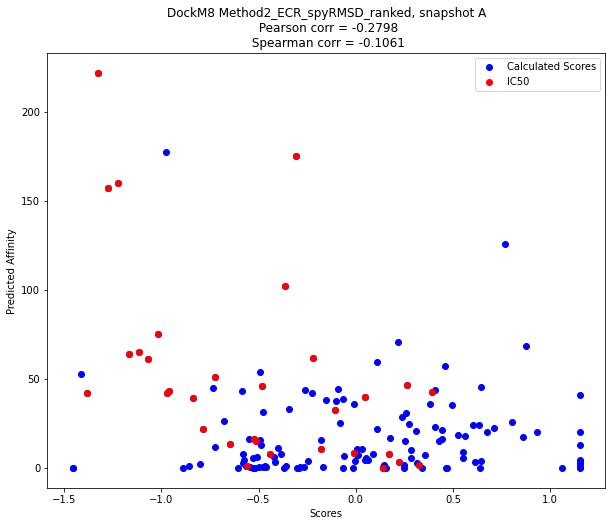

Method2_ECR_RMSD_ranked


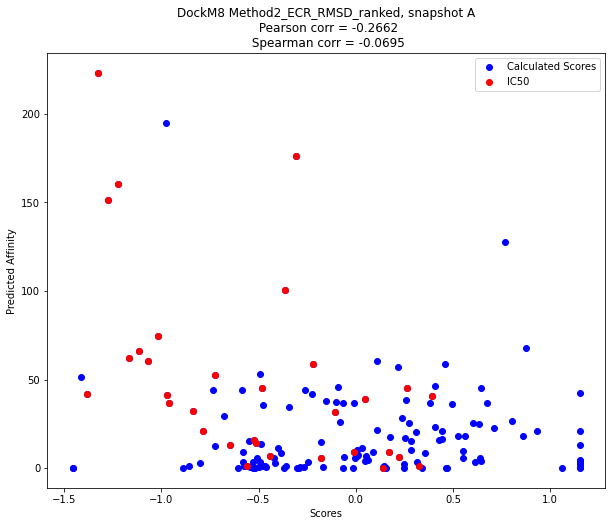

Method2_ECR_spyRMSD_standardised


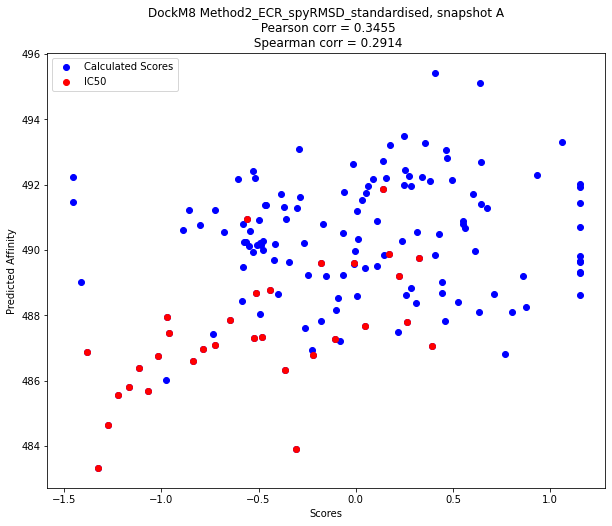

Method2_ECR_bestpose_GNINA_standardised


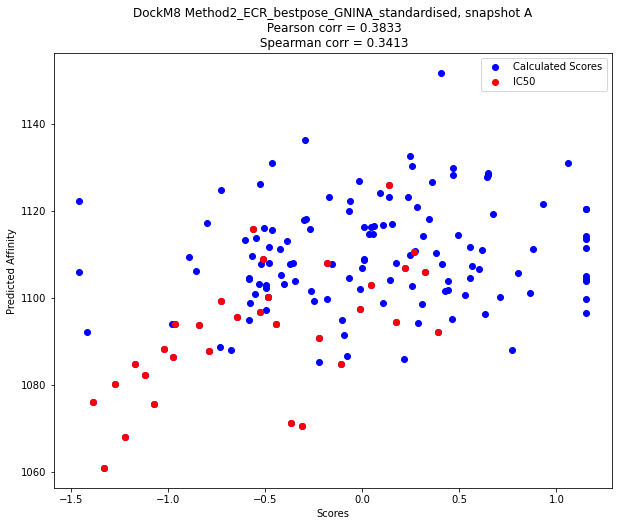

Method2_ECR_bestpose_GNINA_ranked


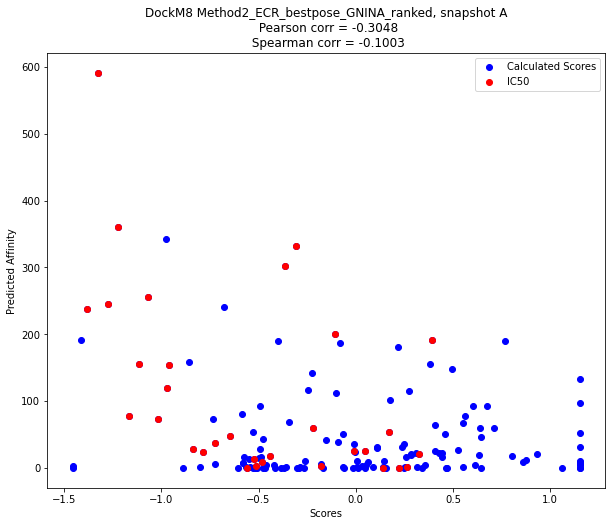

Method2_ECR_bestpose_ranked


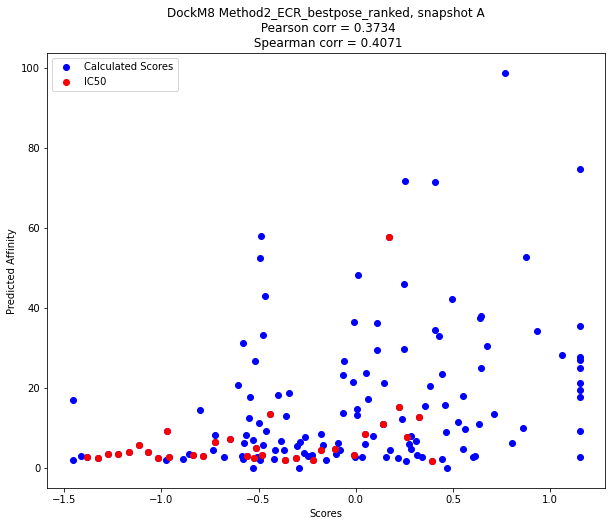

In [12]:
consensus_ranking_generator('method2', common_ID)

#### 3. Z-Score

Method6_Zscore_bestpose_standardised


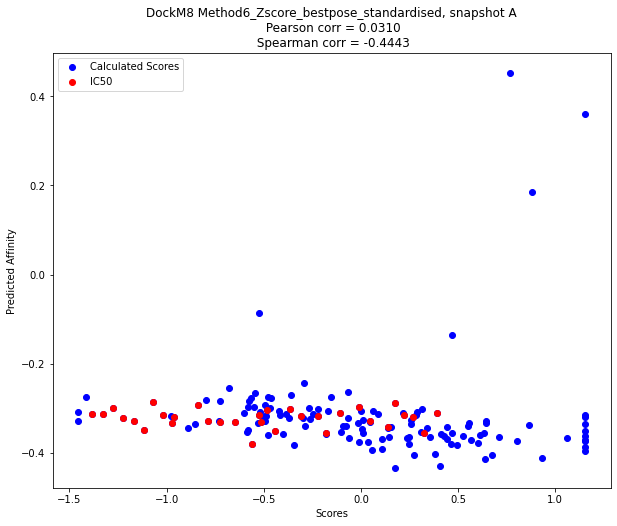

Method6_Zscore_RMSD_standardised


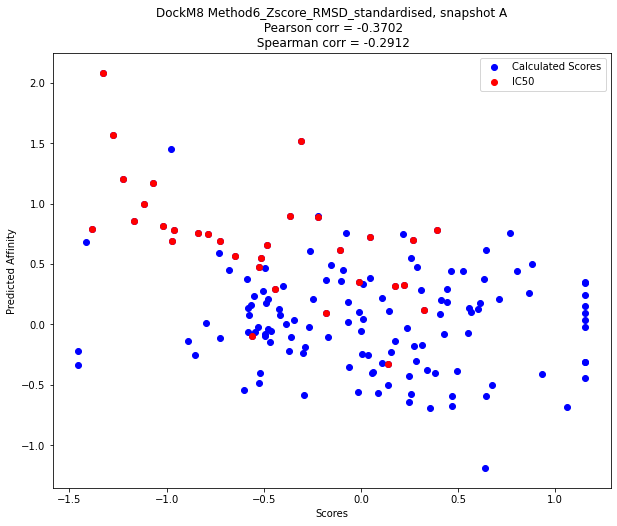

Method6_Zscore_spyRMSD_ranked


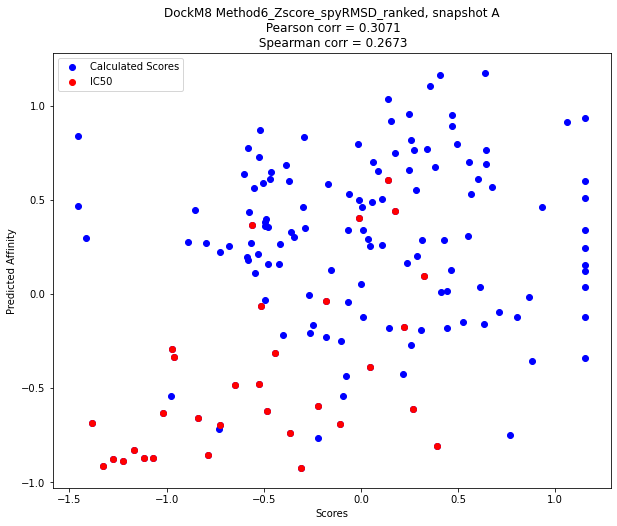

Method6_Zscore_RMSD_ranked


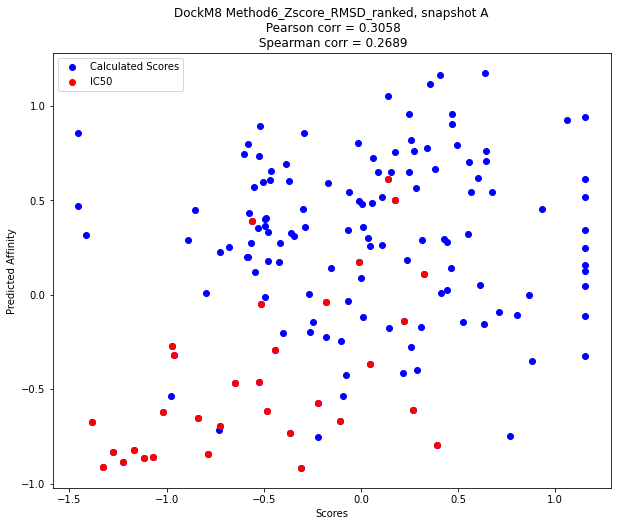

Method6_Zscore_spyRMSD_standardised


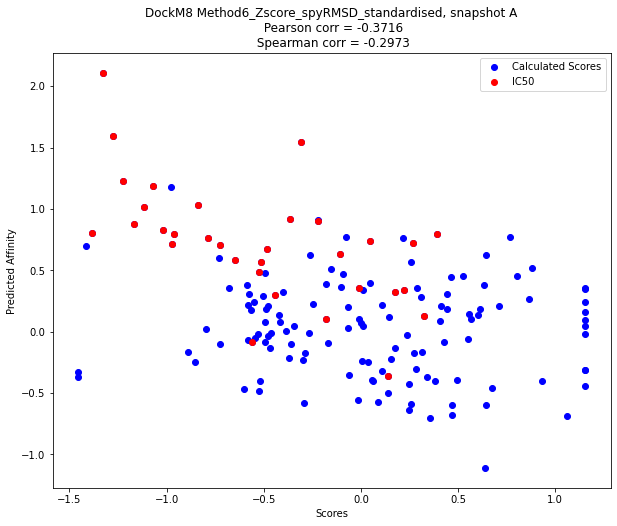

Method6_Zscore_bestpose_GNINA_standardised


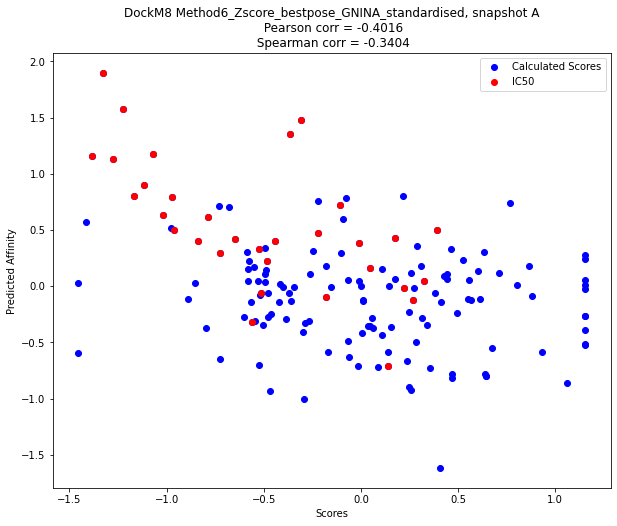

Method6_Zscore_bestpose_GNINA_ranked


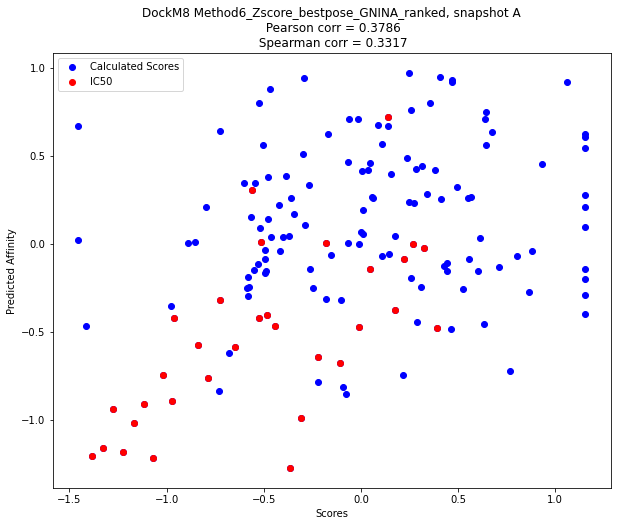

Method6_Zscore_bestpose_ranked


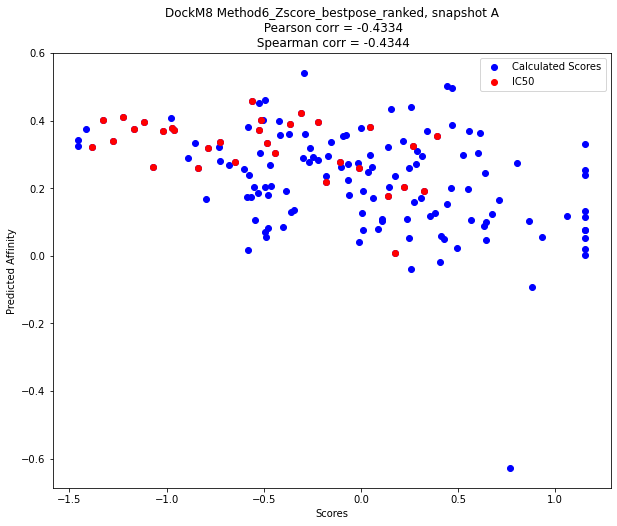

In [13]:
consensus_ranking_generator('method6', common_ID)
